#Step 4 
Optimization with uncertain conversion rates, 𝛼 ratios, and number of items sold per product

In [1]:
import copy

import numpy as np
import matplotlib.pyplot as plt


import Code.utils as utils
import Code.environment.settings as settings
from Code.environment.Environment import Environment
from Code.GreedyLearner import GreedyLearner
from Code.environment.Customer import Customer
from Code.UCBLearner import UCBLearner
from Code.TSLearner import TSLearner
from Code.UCBLearner4 import UCBLearner4
from Code.TSLearner4v2 import TSLearner4

%matplotlib inline

In [2]:
cust_json = "customer3.json"
today_customer = 150
var_cust = 5
p_lambda = 1.0
graph_json = "business_full_graph2.json"

arms = settings.prices
environment = Environment(cust_json,today_customer,var_cust,p_lambda, graph_json, arms)
clairvoyant_arms, clairvoyant_reward, exp_c, rew_per_arm= environment.estimate_clairvoyant()
print("\n", clairvoyant_arms, clairvoyant_reward, exp_c)

loading: [                              ] 0.0%
loading: [=                             ] 1.0%
loading: [=                             ] 2.0%
loading: [=                             ] 2.9%
loading: [==                            ] 3.9%
loading: [==                            ] 4.9%
loading: [==                            ] 5.9%
loading: [===                           ] 6.8%
loading: [===                           ] 7.8%
loading: [===                           ] 8.8%
loading: [===                           ] 9.8%
loading: [====                          ] 10.7%
loading: [====                          ] 11.7%
loading: [====                          ] 12.7%
loading: [=====                         ] 13.7%
loading: [=====                         ] 14.6%
loading: [=====                         ] 15.6%
loading: [=====                         ] 16.6%
loading: [======                        ] 17.6%
loading: [======                        ] 18.6%
loading: [======                        ] 19.5%
loa

In [3]:
n_arms = 4
n_products = 5 

feature1 = 0
feature2 = 0

customer = Customer(feature1, feature2)

TIME_HORIZON = 300
NUM_ITERATION = 5

In [4]:
#unknown parameters
alphas = np.array([0.2, 0.2, 0.2, 0.2, 0.2]) #uniform
prods_dist = np.ones((n_products,n_arms))   #all 1

customers = copy.deepcopy(environment.customers)

for customer in customers:
    customer.set_distribution_alpha(alphas)
    customer.set_num_prods(prods_dist)

UCB

In [5]:
rewards_iterations = []
for i in range(NUM_ITERATION):
    ucb4_learner = UCBLearner4(n_arms, n_products, customers, graph_json, arms, environment.customers_distribution, debug=False)
    print('Iteration #', i+1)
    for t in range(TIME_HORIZON):
        if t % 10 == 0:
            utils.progress_bar(t, TIME_HORIZON)
        super_arm = ucb4_learner.select_superarm()
        report = environment.round(super_arm)
        ucb4_learner.update(super_arm.copy(), report)
    rewards = ucb4_learner.history_rewards
    rewards_iterations.append(np.array(rewards))
rewards_iterations = np.array(rewards_iterations)
rewards_iterations.shape

Iteration # 1
loading: [                              ] 0.0%
loading: [=                             ] 3.3%
loading: [==                            ] 6.7%
loading: [===                           ] 10.0%
loading: [====                          ] 13.3%
loading: [=====                         ] 16.7%
loading: [======                        ] 20.0%
loading: [=======                       ] 23.3%
loading: [========                      ] 26.7%
loading: [=========                     ] 30.0%
loading: [==========                    ] 33.3%
loading: [===========                   ] 36.7%
loading: [============                  ] 40.0%
loading: [=============                 ] 43.3%
loading: [==============                ] 46.7%
loading: [===============               ] 50.0%
loading: [================              ] 53.3%
loading: [=================             ] 56.7%
loading: [==================            ] 60.0%
loading: [===================           ] 63.3%
loading: [===================

(5, 300)

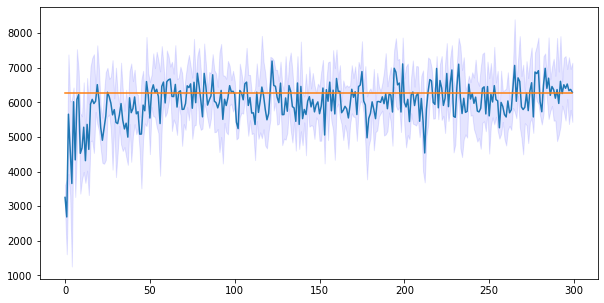

In [6]:
plt.figure(figsize=(10,5))
mean = np.mean(rewards_iterations, axis=0)
stdev = np.std(rewards_iterations, axis=0)

plt.plot(range(len(mean)), mean)
plt.fill_between(range(len(mean)), (mean-stdev), (mean+stdev), color='b', alpha=.1)

plt.plot([_ for _ in range(len(rewards))], [clairvoyant_reward for _ in range(len(rewards))])
plt.show()

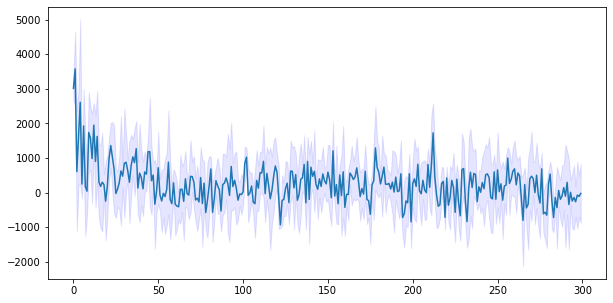

In [7]:
plt.figure(figsize=(10,5))
regret = clairvoyant_reward - rewards_iterations 
mean_regret = np.mean(regret, axis=0)
std_regret = np.std(regret, axis=0)

plt.plot(range(len(mean_regret)), mean_regret)
plt.fill_between(range(len(mean_regret)), (mean_regret-std_regret), (mean_regret+std_regret), color='b', alpha=.1)

plt.show()

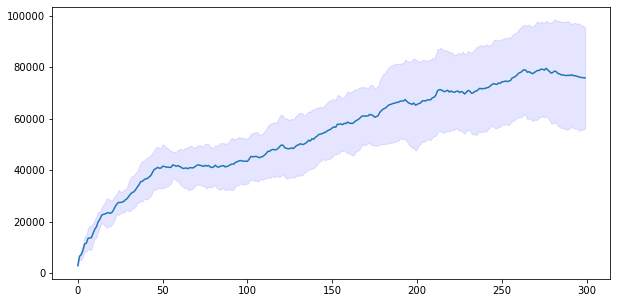

In [8]:
plt.figure(figsize=(10,5))
regret = clairvoyant_reward - rewards_iterations 
cumulative_regret = np.cumsum(regret, axis=1)
cum_reg_mean = np.mean(cumulative_regret, axis=0)
cum_reg_std = np.std(cumulative_regret, axis=0)

plt.plot(range(len(cum_reg_mean)), cum_reg_mean)
plt.fill_between(range(len(cum_reg_mean)), (cum_reg_mean-cum_reg_std), (cum_reg_mean+cum_reg_std), color='b', alpha=.1)

plt.show()

TS

In [9]:
#unknown parameters
alphas = np.array([0.2, 0.2, 0.2, 0.2, 0.2]) #uniform
prods_dist = np.ones((n_products,n_arms))   #all 1

customers = copy.deepcopy(environment.customers)

for customer in customers:
    customer.set_distribution_alpha(alphas)
    customer.set_num_prods(prods_dist)

In [ ]:
rewards_iterations = []
for i in range(NUM_ITERATION):
    ts_learner4 = TSLearner4(n_arms, n_products, customers, graph_json, arms, environment.customers_distribution)
    print('\nIteration #', i+1)
    for t in range(TIME_HORIZON):
        if t % 10 == 0:
            utils.progress_bar(t, TIME_HORIZON)
        super_arm = ts_learner4.select_superarm()
        report = environment.round(super_arm)
        ts_learner4.update(super_arm.copy(), report)
    rewards = ts_learner4.history_rewards
    rewards_iterations.append(np.array(rewards))
rewards_iterations = np.array(rewards_iterations)
rewards_iterations.shape


Iteration # 1
loading: [                              ] 0.0%
loading: [=                             ] 3.3%
loading: [==                            ] 6.7%
loading: [===                           ] 10.0%
loading: [====                          ] 13.3%
loading: [=====                         ] 16.7%
loading: [======                        ] 20.0%
loading: [=======                       ] 23.3%
loading: [========                      ] 26.7%
loading: [=========                     ] 30.0%
loading: [==========                    ] 33.3%
loading: [===========                   ] 36.7%
loading: [============                  ] 40.0%
loading: [=============                 ] 43.3%
loading: [==============                ] 46.7%
loading: [===============               ] 50.0%
loading: [================              ] 53.3%
loading: [=================             ] 56.7%
loading: [==================            ] 60.0%
loading: [===================           ] 63.3%
loading: [==================

In [ ]:
plt.figure(figsize=(10,5))
mean = np.mean(rewards_iterations, axis=0)
stdev = np.std(rewards_iterations, axis=0)

plt.plot(range(len(mean)), mean)
plt.fill_between(range(len(mean)), (mean-stdev), (mean+stdev), color='b', alpha=.1)

plt.plot([_ for _ in range(len(rewards))], [clairvoyant_reward for _ in range(len(rewards))])
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
regret = clairvoyant_reward - rewards_iterations 
mean_regret = np.mean(regret, axis=0)
std_regret = np.std(regret, axis=0)

plt.plot(range(len(mean_regret)), mean_regret)
plt.fill_between(range(len(mean_regret)), (mean_regret-std_regret), (mean_regret+std_regret), color='b', alpha=.1)
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
regret = clairvoyant_reward - rewards_iterations 
cumulative_regret = np.cumsum(regret, axis=1)
cum_reg_mean = np.mean(cumulative_regret, axis=0)
cum_regret_std = np.std(cumulative_regret, axis=0)

plt.plot(range(len(cum_reg_mean)), cum_reg_mean)
plt.fill_between(range(len(cum_reg_mean)), (cum_reg_mean-cum_reg_std), (cum_reg_mean+cum_reg_std), color='b', alpha=.1)
plt.show()

In [ ]:
th_rews = list(rew_per_arm.values())
th_rews.sort()
delta_arms = (th_rews[-1] - th_rews[-2]) / today_customer
seen = np.array(ts_learner4.history_interactions)
theoretical_regret = 1024 * np.log(seen)/delta_arms

In [ ]:
plt.plot(range(len(cum_reg_mean)), cum_reg_mean)
plt.fill_between(range(len(cum_reg_mean)), (cum_reg_mean-cum_reg_std), (cum_reg_mean+cum_reg_std), color='b', alpha=.1)
plt.plot(range(len(theoretical_regret)), theoretical_regret)
plt.show()